###### Author: Himanshu Kulkarni (kulka225@umn.edu)

# Executive Summary

_Situation:_ The client wants to identify best zipcode in New York to purchase properties. They would earn revenue by renting out these properties on a short term. Client already believes that 2 bedroom properties are most profitable.

_Complication:_ The client wants to leverage data to make an informed decision about best zipcode for investment, however, they are unaware of the factors they need to look into and key metrics to be considered

_Recommendation:_ The zip code 10003 followed by 10025 and 10036 are the best zipcodes for making an investment towards long term sustainable growth

_Approach:_ To understand best properties for investment, the business should look at tangible benefits such as return on investment and breakeven period. At the same time, it is important to understand what drives the occupancy and ratings of a property since these are the key metrics which would indicate the sustainability of returns. Hence, the overall approach for the analysis was to jointly look at ROI for zipcodes and number of good quality properties in that zip code. The factors deciding the quality of the property were determined through analysis. We analyzed cost data from Zillow and property listing data from AirBNB for this analysis. Details of the analysis approach and data are present in next section

# Analysis Approach

This section contains the detailed breakdown of the analysis along with rationale behind each stage and conclusions from them

#### Table of contents
1. Approach overview
2. Business constraints and key assumptions
3. Environment setup
4. Analytical dataset creation
5. Analysis 1: Understanding the price trends based on Zillow data
6. Analysis 2: Determining key characteristics that drive high rating
7. Analysis 3: Identifying impact of various factors on property occupancy
8. Analysis 4: Identifying profitable zipcodes based hard benefits
9. Analysis 5: Identifying profitable zipcodes based on soft benefits
10. Conclusions and recommendations
11. Analysis caveats and improvement suggestions

---

### Approach overview

Since business wants to invest in a zipcode, the appraoch is to look at properties in a zipcode based on two key criteria:

1. __Hard benefits:__ Based on investment, rental price and occupancy information, the key metrics such as ROI and breakeven period will be determined which can be direct indicative of the best zipcodes to invest in
2. __Soft benefits:__ Based on various metrics that could further indicate popularity and revenue of properties such as locality, ratings, reviews etc., a more informed decision can be taken about the zipcodes that have comparable hard benefits but could perform differently in a longer run

A combination of these two criteria will indicate the best zipcodes to make an investment.

---

### Business constraints and key assumptions

The analysis is base on some of the hard constraints provided by the business. Based on these constraints, some assumptions have been taken as follows:

###### Constraints:

1. City under consideration is 'New York'
2. Only the properties with 2 bedrooms have been considered for analysis as business has concluded that two bedroom properties are most profitable
3. The business strategy focuses on renting out for short-term


###### Assumptions

1. Given: The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for)
2. Given: The time value of money discount rate is 0% (i.e. USD 1 today is worth the same 100 years from now)
3. Given: All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)
4. Based on assumption 3, only daily price from AirBNB will be considered for analysis (discounted weekly and monthly price won't be used)
5. Some assumptions have been made regarding fields to be considered from AirBNB dataset for the scope of this problem, they can be found under 'AirBNB ADS creation' section
6. The availability is assumed to be result of other bookings and not due to other factors such as periodic closing of property or construction at property etc.
7. __A new method for calculating occupancy rate has been adopted using 30 day and 60 day out availability in the dataset, the explanation and formula can be found under 'AirBNB ADS creation' section__


---

### Environment setup

This section will have following components:

1. Load required packages
2. Read data files
3. Declare some user defined functions
4. Declare global constraint variables (__Make changes here to scale the analysis to more regions__)

In [1]:
# Load required packages
import pandas as pd
import ggplot as gp
import dfply as dp
import math
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import normalize

# Hiding deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Declaring useful functions

# This function cleans currency column and converts to appropriate data format
def convert_currency(df, colname):
    df[colname] = df[colname].astype(str)
    df[colname] = df[colname].apply(lambda x: x.replace('$', ''))
    df[colname] = df[colname].apply(lambda x: x.replace(',', ''))
    df[colname] = df[colname].astype(float)
    return df[colname]

# This function is useful in treating missing values based on a certain group
def replace_groupmean(df, colname, groupname):
    df[colname] = df.groupby(groupname).transform(lambda x: x.fillna(x.mean()))
    return df[colname]


# Import datasets for analysis
zil = pd.read_csv('Zip_Zhvi_2bedroom.csv')
abnb = pd.read_csv('listings.csv')

# Declaring global business constraints and variables
CITY = 'New York'
BEDROOMS = 2
ANALYSIS_MONTH = '2017-05'

C:\Users\himan\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


### Analytical dataset creation

Analytical dataset creation will perform following activities for both Zillow and AirBNB data:

1. Take required columns from the data
2. Subset the data based on business constraints
2. Perform necessary data type conversions
3. Remove following issues:
    1. Missing values
    2. Duplicates
    3. Outliers
    4. Other data cleaning e.g. currency sign in price columns
4. Make other naming conventions consistent

Post this section, the data will be ready for analysis

##### Zillow data ADS creation

In [2]:
# Changing structure of data
zil_analysis = zil >> \
               dp.gather('YM', 'cost', dp.columns_from(dp.X['1996-04'])) >>\
               dp.mask(dp.X.City == CITY)

# Remove duplicates
zil_analysis = zil_analysis.drop_duplicates()

# Check for missing values
print(zil_analysis.isna().any())

# Check for % missing values
print('\n Percentage of missing values:' +
      str(100 * len(zil_analysis.cost.loc[zil_analysis.cost.isna()]) /
          len(zil_analysis.cost)))

RegionID      False
RegionName    False
City          False
State         False
Metro         False
CountyName    False
SizeRank      False
YM            False
cost           True
dtype: bool

 Percentage of missing values:26.603921568627452


The cost column has high percentage of missing values. However, since the final cost that we want to look at is corresponding to the AirBNB data, we would like to ensure that there are no missing values corresponding to year month May 2017 which is our analysis month.

In [3]:
zil_analysis.loc[zil_analysis.YM == ANALYSIS_MONTH].isna().any()

RegionID      False
RegionName    False
City          False
State         False
Metro         False
CountyName    False
SizeRank      False
YM            False
cost          False
dtype: bool

There are no missing values for the duration under consideration. Hence, no missing value treatement is required at this point.
Moreover, since cost for each zipcode will provide the investment amount, due to presence of just 25 zipcodes, we should not perform any outlier treatment.

Finally, checking if the zipcodes are in appropriate format

In [4]:
zil_analysis.RegionName.unique()

array([10025, 10023, 10128, 10011, 10003, 11201, 11234, 10314, 11215,
       10028, 10021, 10014, 10036, 11434, 10306, 10312, 10022, 11217,
       10013, 11231, 10304, 10305, 10309, 10308, 10303], dtype=int64)

The zipcodes are in clean 5 digit format, hence the __preprocessing of Zillow data is complete.__

##### AirBNB data ADS creation

Note: Since the business has identified two-bedroom properties to be most profitable, we will try to analyze only these properties

The columns to be included for this analysis have been shortlisted based on several criteria/assumptions as follows:

1. All the URL columns have been excluded
2. Descriptive such as notes, amenities, transportation, rules etc. columns have been excluded as they are subjective to the host putting up the listing and not comparable across listings
3. Some of the fields that could be summarized by other fields with safe assumptions have been excluded:
    1. Since we are looking only at two bedrooms, number of bedrooms, baths, bedrooms, bed types have been excluded assuming that the properties will have similar characteristics
    2. Details about host such as verifications, host response rate, host respons time, host neighborhood etc. have been removed assuming these fields will reflect on various rating scores and superhost information
    3. Some of the fields regarding country, state etc. have been removed since we are looking only at New York properties, this should be done since comparing cities across different states might not be ideal

In [5]:
# Selecting relevant columns for the analysis based on assumption
abnb_analysis = abnb >> \
                dp.mask(dp.X.bedrooms == BEDROOMS) >> \
                dp.select(
                          'id', 'host_is_superhost',
                          'host_total_listings_count', 'neighbourhood_cleansed',
                          'neighbourhood_group_cleansed', 'zipcode', 'market',
                          'latitude', 'longitude',
                          'property_type', 'room_type',
                          'square_feet',
                          'price',
                          'cleaning_fee', 'guests_included', 'minimum_nights',
                          'maximum_nights',
                          'availability_30', 'availability_60', 'availability_90',
                          'availability_365', 'number_of_reviews',
                          'review_scores_rating',
                          'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication',
                          'review_scores_location', 'review_scores_value',
                          'instant_bookable',
                          'cancellation_policy',
                          'reviews_per_month')

# Removing duplicates
abnb_analysis = abnb_analysis.drop_duplicates()

# Cleaning price column for float type conversion
abnb_analysis.price = convert_currency(abnb_analysis, 'price')

# Obsrving zipcodes
abnb_analysis.zipcode.unique()

array(['10462', '10469', '11102', '11105', nan, '11370', '11417', '11416',
       '10458', '10305', '11692', '11103', '11106', '11101', '11356',
       '11228', '10006', '10004', '10280', '11209', '11220', '11360',
       '11233', '11221', '11216', '11213', '11238', '11205', '11206',
       '11237', '11694', '11001', '11426', '11426-1175', '11214', '11204',
       '11201', '11217', '11218', '11219', '11235', '11224', '11225',
       '11226', '11203', '10455', '10454', '11212', '11207', '11385',
       '10002', '10013', '10038', '11236', '11231', '10011', '10010',
       '10001', '10003', '10014', '10036', '10473', '10304', '10451',
       '10452', '11368', '10465', '11208', '11369', '11210', '10029',
       '10026', '10035', '10037', '10128', '10027', '10459', '11373',
       '10012', '10009', '10003-8623', '10016', '10475', '11691', '10270',
       '10005', '11230', '11234', '11358', '11354', 11354.0, 11358.0,
       11355.0, 11367.0, 11215.0, 11217.0, 11231.0, 11201.0, 11375.0,
     

It can be observed from the data that some of the zip codes are not clean, they are in float format or have '-' subscript hence they need to be cleaned. We will consider only first 5 digits of these zipcodes

In [6]:
abnb_analysis.zipcode = abnb_analysis.zipcode.astype(str)
abnb_analysis.zipcode = abnb_analysis.zipcode.apply(lambda x: x[0:5])
abnb_analysis = abnb_analysis.loc[abnb_analysis.zipcode != 'nan']
abnb_analysis.zipcode = abnb_analysis.zipcode.astype(int)


In [7]:
# Subsetting the data for the zipcodes with cost information
abnb_analysis = abnb_analysis.loc[abnb_analysis.zipcode.\
                                  isin(list(zil_analysis.RegionName))]

# Checking for missing values
abnb_analysis.isna().any()

id                              False
host_is_superhost                True
host_total_listings_count        True
neighbourhood_cleansed          False
neighbourhood_group_cleansed    False
zipcode                         False
market                           True
latitude                        False
longitude                       False
property_type                   False
room_type                       False
square_feet                      True
price                           False
cleaning_fee                     True
guests_included                 False
minimum_nights                  False
maximum_nights                  False
availability_30                 False
availability_60                 False
availability_90                 False
availability_365                False
number_of_reviews               False
review_scores_rating             True
review_scores_accuracy           True
review_scores_cleanliness        True
review_scores_checkin            True
review_score

We observe that there are some missing values for some columns however, the key informative columns such as zipcode, price and occupancy that will be used for hard benefit calculation do not have any missing values. Hence no missing value treatement is performed at this point. However, some missing values will need to be treated based on analysis requirement later.

Now we will perform outlier detection for price to remove properties with unrealistic values

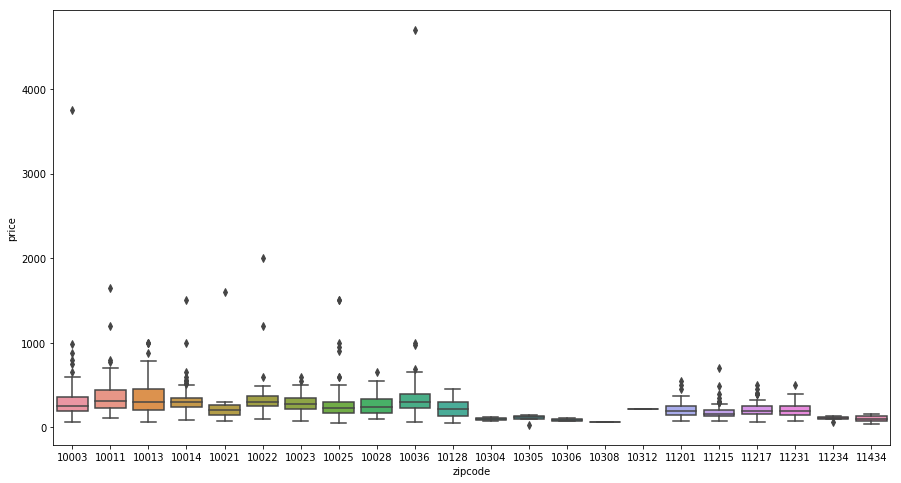

In [8]:
# Checking price outliers
fig, ax = plt.subplots(figsize=(15, 8))
sb.boxplot(x=abnb_analysis.zipcode, y=abnb_analysis.price, ax=ax)

Based on the graph above, it can be observed that overall the price above __USD 800__ can be considered as extremely costly as this threshold covers major outliers from most of the zip codes. Hence we will flag these properties as extremely expensive.

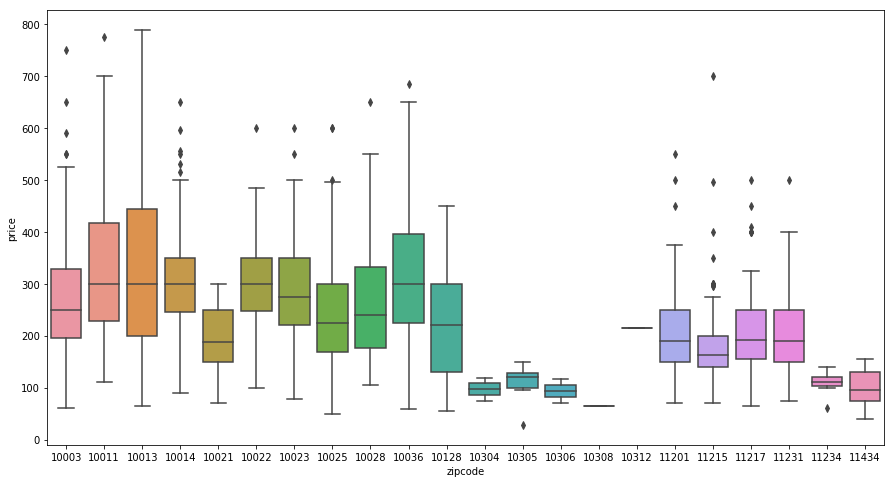

In [9]:
abnb_analysis['expensive'] = abnb_analysis.price.\
                             apply(lambda x: 'exp' if x >= 800 else 'normal')
fig, ax = plt.subplots(figsize=(15, 8))
sb.boxplot(x=abnb_analysis.zipcode.loc[abnb_analysis.expensive == 'normal'],
           y=abnb_analysis.price.loc[abnb_analysis.expensive == 'normal'], ax=ax)

Now let's explore occupancy for various properties

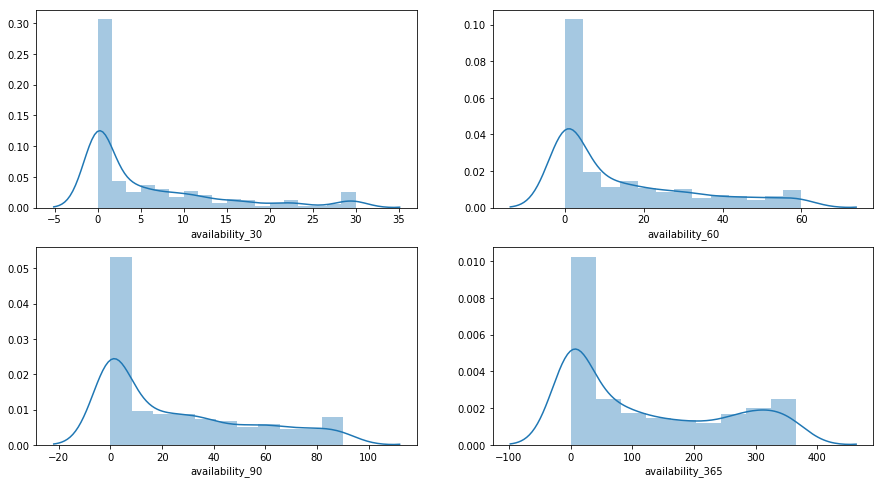

In [10]:
fig, ax =plt.subplots(2,2, figsize=(15, 8))
sb.distplot(abnb_analysis.availability_30, ax=ax[0, 0])
sb.distplot(abnb_analysis.availability_60, ax=ax[0, 1])
sb.distplot(abnb_analysis.availability_90, ax=ax[1, 0])
sb.distplot(abnb_analysis.availability_365, ax=ax[1, 1])
fig.show()

Based on above graphs (especially avaiability in 30 and 60 days), we can infer that as the date of stay comes nearby, a good amount of properties start getting filled completely and hence assuming a general occupany of 75% might undermine actual revenue generated in case of some properties. At the same time it could also boost occupancy rate of some of the properties which do not have sufficient occupancy. Hence, to determine occupancy, we will use average 30 day occupancy and 60 day occupancy (to normalize any surge due to 30 day occupancy).

__Hence new occupancy will be determined as:__

__Occupancy % = ((30 - availability_30) / 30 + (60 - availability_60) / 60) / 2__

Adding the new occupancy rate column:

0.7836830777508744
0.9166666666666667


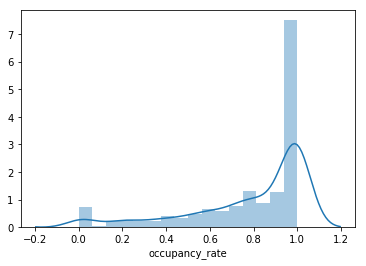

In [11]:
abnb_analysis['occupancy_rate'] = ((30 - abnb_analysis.availability_30) / 30 +\
                                   (60 - abnb_analysis.availability_60) / 60) / 2
sb.distplot(abnb_analysis.occupancy_rate)

# Checking mean occupancy
print(abnb_analysis.occupancy_rate.mean())

# Checking median occupancy
print(abnb_analysis.occupancy_rate.median())

As it can be observed, mean occupancy calculated by this method is 78% which is assumed by the business. However, median occupancy is around 91% which means many of the properties are performing better than the business expects. Hence we will use this occupany rate for further analysis.

At this point, we have extracted required data, cleaned it and adressed outliers. __Hence AirBNB data preprocessing is complete.__

### Analysis 1: Understanding the price trends based on Zillow data

_Rationale:_

Observing the price trend across various zip codes could help us identify the zip codes which have seen growth over time in terms of real estate valuation. This growth could be attributed to the zipcodes being prime locations. There is a good chance that these zipcodes have:
1. Good presence of businesses resulting in high volume of short term business travellers
2. Great connectivity and neighborhood with easy accessibility to services and amenities
3. Overall better quality of living

Investing in these properties could help the business generate revenue by applying appropriate pricing strategy. This could also mean long term benefits on resale.

_Key Goal:_

Identify growth trends across zipcodes


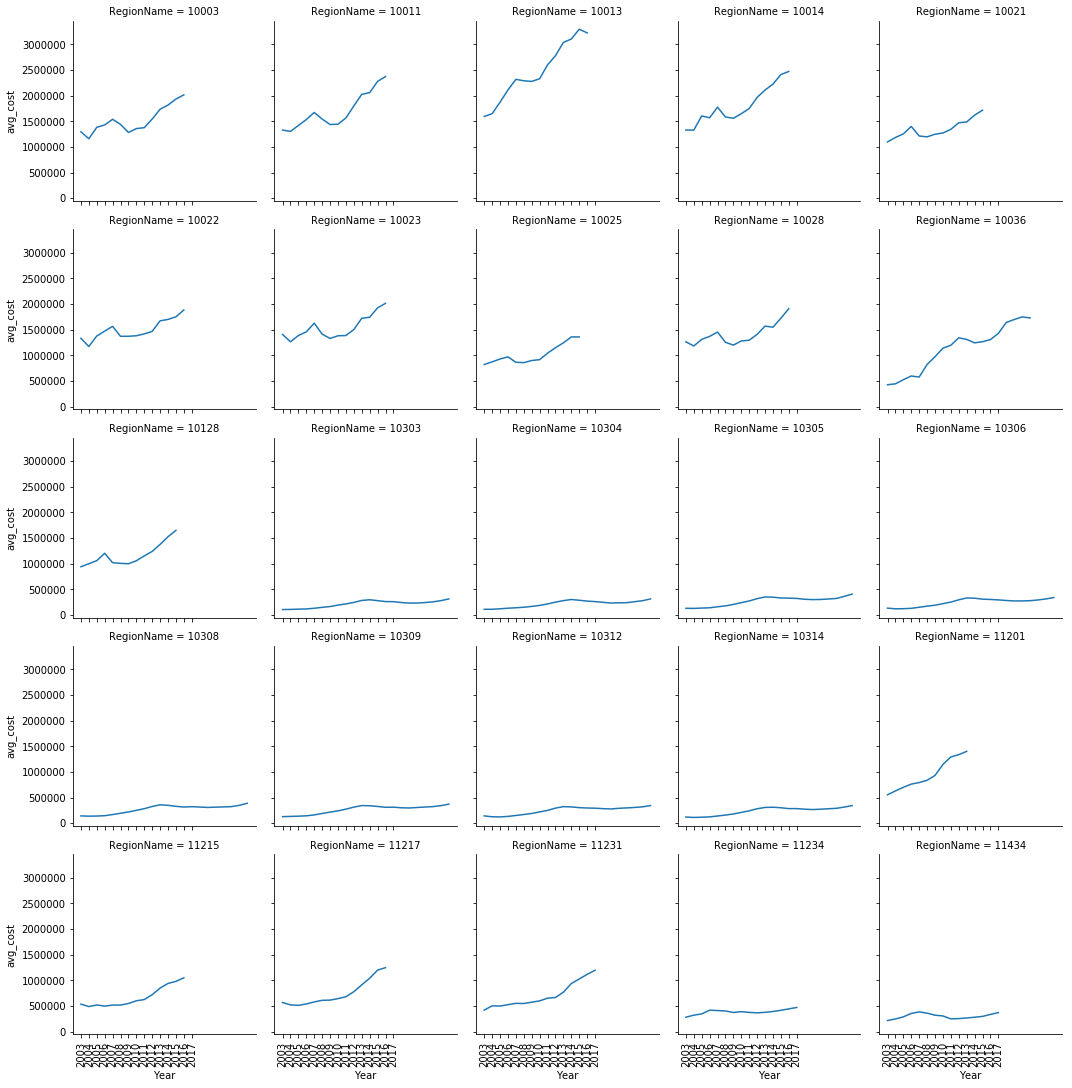

In [12]:
# Identifying cost trends over years
cost_trend = zil_analysis
cost_trend['Year'] = zil_analysis.YM.apply(lambda x: x[0:4])
cost_trend = cost_trend >> \
             dp.group_by(dp.X.RegionName, dp.X.Year) >>\
             dp.summarize(avg_cost = dp.X.cost.mean())
g11 = sb.FacetGrid(cost_trend, col='RegionName',  col_wrap=5)
g11 = g11.map(plt.plot, 'Year', 'avg_cost')
g11.set_xticklabels(rotation=90)


_Conclusion:_

Based on observed YOY cost trends, the overall zipcodes can be categorized in following way:

1. __Dynamic regions__: These are high value and high growth rate zipcodes which are: 10011 to 10014 and 10036. The high investment in these regions could come with a risk of long term breakeven
2. __Promising regions__: These are moderate valued zips with significant growth: 10003, 10021 to 10028, 10128, 11201. Investing in them could be cost effective and provide long term benefits
3. __Passive regions__: These zipcodes have not shown promising growh over years hence even though we can get a good ROI in these regions, the overall revenue might still be low: 10303 to 10314, 11215 to 11434

From above observation, the promising regions appear to be most ideal for investment

In [13]:
# Including these findings in the Zillow data

zil_analysis['zip_cat'] = 'ph'
zil_analysis.zip_cat.loc[(zil_analysis.RegionName.between(10309, 11234)) | \
                         (zil_analysis.RegionName.between(11215, 11434))] = 'Passive'
zil_analysis.zip_cat.loc[(zil_analysis.RegionName.between(10011, 10014)) | \
                         (zil_analysis.RegionName == 10036)] = 'Dynamic'
zil_analysis.zip_cat.loc[zil_analysis.zip_cat == 'ph'] = 'Promising'

### Analysis 2: Determining key characteristics that drive high rating

_Rationale:_

The first criteria towards  chosing a property for stay by travellers is usually the rating given. Even though for a particular property, rating might be high just because number of reviews is low, understanding the property characteristic that contributes most to the overall property rating could be helpful in making strategic decisions towards picking up the zipcode for investment with maximum such characteristic. For example, if location score contributes most to the overall rating, we should try to invest in zipcode with properties having high location score.

_Key Goal:_

Determine how various property characteristics affect overall rating

We will perform simple regression analysis for significance testing and try to draw causal inference from it. Since the properties are located in same city and there is no effect over time, we can safely assume all confounders to be taken care of.

In [14]:
rating = abnb_analysis[['review_scores_rating', 'review_scores_accuracy',
                        'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication',
                          'review_scores_location', 'review_scores_value']]

rating = rating.dropna()
Y = rating['review_scores_rating']
X = rating.drop('review_scores_rating', axis=1)

# Since all columns contain rating, they are in same scale and
# we dont need to perform any transformation
rate_reg = sm.OLS(Y, X).fit()
rate_reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     review_scores_rating   R-squared:                       0.998
Model:                              OLS   Adj. R-squared:                  0.998
Method:                   Least Squares   F-statistic:                 8.869e+04
Date:                  Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                          22:43:32   Log-Likelihood:                -2705.6
No. Observations:                   967   AIC:                             5423.
Df Residuals:                       961   BIC:                             5452.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
review_scores_accuracy          2.8664      0.242     11.860      0.000       2.392       3.341
review_scores_cleanliness       1.7579      0.159     11.089      0.000       1.447       2.069
review_scores_checkin           0.4595      0.240      1.918      0.055      -0.011       0.930
review_scores_communication     1.7605      0.274      6.425      0.000       1.223       2.298
review_scores_location          0.6200      0.200      3.104      0.002       0.228       1.012
review_scores_value             2.3780      0.216     10.997      0.000       1.954       2.802
==============================================================================
Omnibus:                      234.611   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1181.933
Skew:                          -1.021   Prob(JB):                    2.22e-257
Kurtosis:                       8.016   Cond. No.                         59.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on above analysis, we could draw conclusions that:

1. Accuracy of information is most important in getting high rating
2. This is followed by value for money as the next most important characteristic
3. Property location surprisingly does not contribute a lot to overall score (This could be due to the fact that all properties are in similar location overall due to narrow scope of search)

However, we would also like to check relationship between number of reviews given and the rating received. for example, rating of 100 from 20 reviews is definitely better than rating of 100 from 1 review

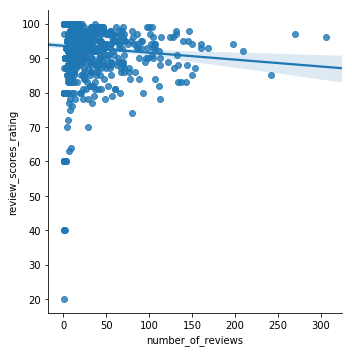

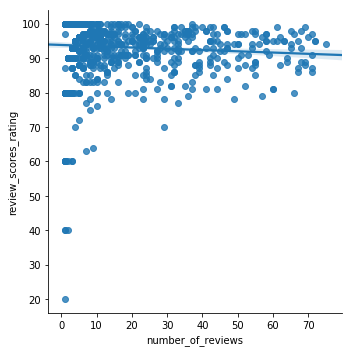

In [15]:
# Relationship between overall ratings and number of ratings given
sb.lmplot(x='number_of_reviews',y='review_scores_rating', data=abnb_analysis)
sb.lmplot(x='number_of_reviews',y='review_scores_rating',
          data=abnb_analysis.loc[abnb_analysis.number_of_reviews <= 75])

_Conclusion:_

The first plot shows that there is slight decline in average score as number of ratings increases which is expected since more sample of people would result in variety of rating even for similar experience. However, after removing few highly rated properties, we can observe that the relationship between ratings and number of reviews almost becomes flat.

Hence, overall we can conclude that host providing highly accurate information and value for money is most likely to recieve great ratings and additionally we would like to have more number of ratings provided to bolster the quality of property.

### Analysis  3: Identifying impact of various factors on property occupancy

_Rationale:_

In this approach we try to understand how various factors affect the occupancy of a property. Based on how other factors impact this occupancy, business can adopt a strategy to focus on the zipcodes having best of these factors such as: Investing in zip-codes that have high number of 'super-hosts'

_Key Goal:_

Understand factors that have significant impact on occupancy of property

We will perform simple regression analysis for significance testing and try to draw causal inference from it. Since the properties are located in same city and there is no effect over time, we can safely assume all confounders to be taken care of. That's why, for the purpose of this analysis, we will not consider variables related to location.

In [16]:
occupancy = abnb_analysis[['occupancy_rate', 'host_is_superhost',
                          'property_type', 'room_type',
                          'square_feet',
                          'price',
                          'guests_included', 'minimum_nights',
                          'maximum_nights',
                          'review_scores_rating','instant_bookable',
                          'cancellation_policy',
                          'reviews_per_month', 'expensive']]
occupancy = occupancy.loc[occupancy.expensive=='normal']
occupancy = occupancy.dropna()
occupancy = occupancy.drop('expensive', axis=1)
occupancy = pd.get_dummies(occupancy)
Y = occupancy['occupancy_rate']
X = occupancy.drop('occupancy_rate', axis=1)
# temp = X.columns
# X = pd.DataFrame(normalize(X), columns=temp)
rate_reg = sm.OLS(Y, X).fit()
rate_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         occupancy_rate   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     3.167
Date:                Fri, 22 Mar 2019   Prob (F-statistic):             0.0307
Time:                        22:43:33   Log-Likelihood:                 23.924
No. Observations:                  26   AIC:                            -17.85
Df Residuals:                      11   BIC:                             1.024
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
square_feet                      0.0002      0.000      1.913      0.082   -3.64e-05       0.001
price                           -0.0013      0.000     -4.836      0.001      -0.002      -0.001
guests_included                 -0.0682      0.042     -1.617      0.134      -0.161       0.025
minimum_nights                  -0.0015      0.004     -0.356      0.728      -0.011       0.008
maximum_nights                   0.0001   9.45e-05      1.202      0.255   -9.44e-05       0.000
review_scores_rating             0.0240      0.010      2.436      0.033       0.002       0.046
reviews_per_month               -0.0663      0.036     -1.836      0.093      -0.146       0.013
host_is_superhost_f             -0.1748      0.240     -0.728      0.482      -0.703       0.354
host_is_superhost_t             -0.2863      0.244     -1.172      0.266      -0.824       0.251
property_type_Apartment          0.1931      0.198      0.977      0.349      -0.242       0.628
property_type_House             -0.3663      0.157     -2.333      0.040      -0.712      -0.021
property_type_Loft              -0.2879      0.232     -1.240      0.241      -0.799       0.223
room_type_Entire home/apt       -0.5083      0.251     -2.022      0.068      -1.062       0.045
room_type_Private room           0.0472      0.314      0.150      0.883      -0.645       0.739
instant_bookable_f              -0.3856      0.247     -1.563      0.146      -0.929       0.158
instant_bookable_t              -0.0755      0.225     -0.336      0.743      -0.570       0.419
cancellation_policy_flexible    -0.0924      0.194     -0.477      0.643      -0.519       0.334
cancellation_policy_moderate    -0.1397      0.171     -0.818      0.431      -0.516       0.236
cancellation_policy_strict      -0.2291      0.150     -1.524      0.156      -0.560       0.102
==============================================================================
Omnibus:                        0.233   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.092
Skew:                          -0.129   Prob(JB):                        0.955
Kurtosis:                       2.866   Cond. No.                     2.92e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.51e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

_Conclusion:_

Based on above results, we can safely conclude that, in precense of price (which we assume to be a major criteria in driving occupancy and would not remove is since it might explode the coefficients for other variables out of proportion), only the overall rating affects positively on the occupancy. Hence, we will disregard other factors as most of the other characteristics can be captured by ratings


### Analysis 4: Identifying profitable zipcodes based hard benefits

_Rationale:_

Based on the investment indicated from Zillow data and price information from AirBNB data, we can calculate ROI (return on investment) and breakeven period for the investment. Ideally, we would want to invest in zipcodes with high ROI and low breakeven periods. These metrics would be direct indicators of best zipcodes to invest in

_Key Goal:_

Calculate ROI and Breakeven period for various zip codes


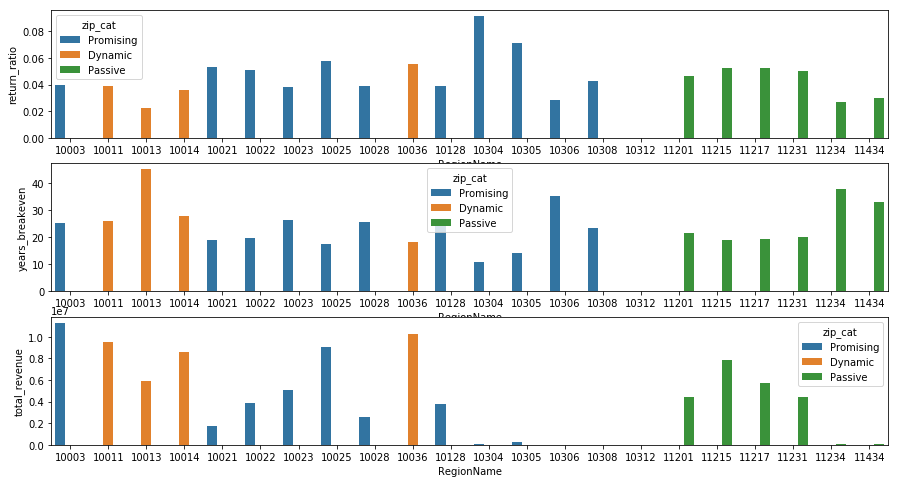

In [17]:
zil_roi = zil_analysis.loc[zil_analysis.YM == ANALYSIS_MONTH]
abnb_roi = abnb_analysis >> \
           dp.rename(RegionName=dp.X.zipcode) >> \
           dp.mutate(annual_rev = dp.X.price * dp.X.occupancy_rate * 365) >> \
           dp.group_by(dp.X.RegionName) >> \
           dp.summarize(total_revenue = dp.X.annual_rev.sum(),
                        expensive_props = dp.n(dp.X.expensive[dp.X.expensive=='exp']),
                        total_props = dp.n(dp.X.id))
roi = pd.merge(zil_roi, abnb_roi, on='RegionName', how='left')
roi = roi.dropna()
roi['return_ratio'] = roi.total_revenue / (roi.cost * roi.total_props)
roi['years_breakeven'] = roi.cost * roi.total_props / roi.total_revenue
roi.RegionName = roi.RegionName.astype(str)
fig, ax =plt.subplots(3,1, figsize=(15, 8))
sb.barplot(x='RegionName', y='return_ratio', hue='zip_cat', data=roi, ax=ax[0])
sb.barplot(x='RegionName', y='years_breakeven', hue='zip_cat', data=roi, ax=ax[1])
sb.barplot(x='RegionName', y='total_revenue', hue='zip_cat', data=roi, ax=ax[2])
fig.show()

_Conclusion_

1. In this case, considering only the returns ration and breakeven years would not be ideal since even the returns ratio for some zips is very high, the revenue generated is not good enough for future growth and bringing in big amounts of cash flow
2. Moreover, these zipcodes which have comparable ROA still have about 10 15 years of breakeven period. 
3. Hence business should target zip codes 10003 and 10025 which have breakeven period around average but they will contribute to a steady cash flow of a significant amount for future investment prospects (as these zipcodes lie in promising growth category)
4. We can also target couple of dynamic zipcodes such as 10036 and 10011 that are growing at a high rate and prove to be a valuable asset in longer run

### Analysis 5: Identifying profitable zipcodes based on soft benefits

_Rationale:_

Based on the factors that impact the popularity of properties, it is important to determine which properties and zip-codes will be more beneficial in longer run. This analysis would particularly be helpful in choosing to invest between zip codes which have comparable ROI and breakeven period. For example, if one zipcode has more reviews (which indicates more popularity) than other zipcode with comparable ROI, it is advisable to invest in the one with more reviews

_Key Goal:_

Identify best zipcodes to invest in based on both hard and soft benefits

From analysis 2 and 3 we have understood that users value information accuracy and value for money highly while giving ratings. We also know that we should look for properties with high number of reviews received to remove any samling bias. Lastly, price is one of the important factors that drives occupancy hence we would want to avoid unreasonably proiced properties. 

Hence combining all the information together and checking the zipcodes shortlisted based on previous analysis:

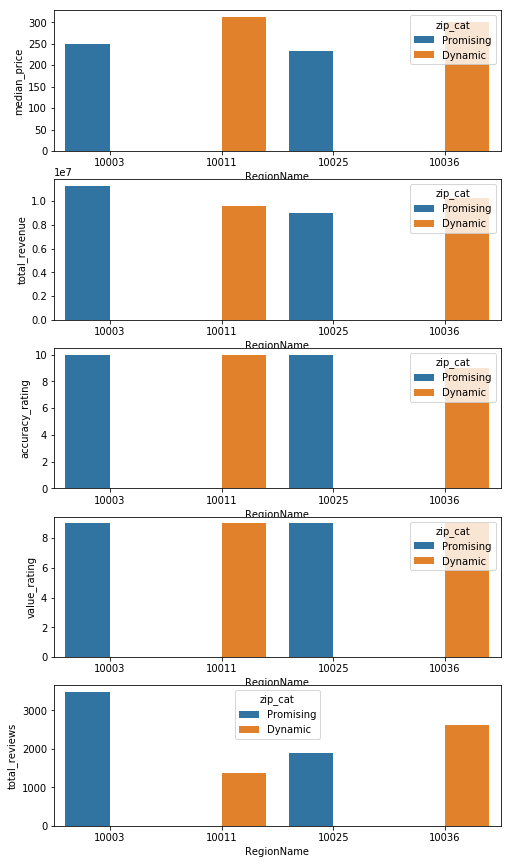

In [18]:
zil_fin = zil_analysis.loc[zil_analysis.YM == ANALYSIS_MONTH]
abnb_fin = abnb_analysis >> \
           dp.rename(RegionName=dp.X.zipcode) >> \
           dp.mutate(annual_rev = dp.X.price * dp.X.occupancy_rate * 365) >> \
           dp.group_by(dp.X.RegionName) >> \
           dp.summarize(total_revenue = dp.X.annual_rev.sum(),
                        expensive_props = dp.n(dp.X.expensive[dp.X.expensive=='exp']),
                        total_props = dp.n(dp.X.id),
                        accuracy_rating = dp.X.review_scores_accuracy.median(),
                        value_rating = dp.X.review_scores_value.median(),
                        total_reviews = dp.X.number_of_reviews.sum(),
                        median_price = dp.X.price.median())
fin = pd.merge(zil_fin, abnb_fin, on='RegionName', how='left')
fin = fin.dropna()
fin = fin.loc[fin.RegionName.isin([10003, 10025, 10011, 10036])]
fig, ax =plt.subplots(5,1, figsize=(8, 15))
sb.barplot(x='RegionName', y='median_price', hue='zip_cat', data=fin, ax=ax[0])
sb.barplot(x='RegionName', y='total_revenue', hue='zip_cat', data=fin, ax=ax[1])
sb.barplot(x='RegionName', y='accuracy_rating', hue='zip_cat', data=fin, ax=ax[2])
sb.barplot(x='RegionName', y='value_rating', hue='zip_cat', data=fin, ax=ax[3])
sb.barplot(x='RegionName', y='total_reviews', hue='zip_cat', data=fin, ax=ax[4])
fig.show()

_Conclusion:_

1. All other zipcodes except 10011 fails at 2 of the soft benefits criteria which are total reviews and median price of properties
2. Based on various criteria and analysis done, 10003 appears to be the best zipcode to invest in
3. At the same time 10025 and 10036 are also great options for consideration

### Conclusions and recommendations

1. Based on analysis, zip code 10003 is best for investment while 10025 and 10036 are also good options
2. This recommendation is based on following factors:
    1. Growth prospect of zipcode
    2. Revenue and breakeven metrics
    3. User experience and occupancy metrics
3. Business should consider changing the assumption of flat 75% occupancy based on observations in data
4. Various metrics have been provided to the business for all properties for exploring further options

### Analysis caveats and improvement suggestions

1. Current analysis does not take into consideration the subjective/textual data which could be a great indicator of additional information regarding host and the property which could cater to specific segment of guests. Consider using this data for further analysis through text mining which could provide more information
2. The AirBNB data has not been considered over time, if collected over time, this data could provide valuable insights towards property popularity trends and more robust pricing strategy could be devised
3. Through analysis it was established logically through data that occupancy rate is more than 75% hence the analysis migh need to be done with lesser constraints such as only 2 bedroom properties are assumed to be profitable
4. There were missing values in the data leading to inherent assumptions in the analysis, a cleaner data could be collected to ensure robust results
5. Some of the factors were assumed to represent other factors (e.g. superhost indicative of his response speed, response rate, verification etc.) which might not always be the case, a more in depth analysis could be performed to tackle these assumptions to find more accurate drivers of occupancy
6. The analysis is limited to the AiBNB and Zillow data while occupancy can be highly driven by locality and connectivity for short term stays, hence more publically available data should be collected